# CIFAR10 Classification

In this part of the assignment we want to do an image classification task using PyTorch on CIFAR10 dataset.

## Import Libraries

Import needed libraries

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from time import time
import tqdm
from sklearn.manifold import TSNE

## Device

Set device to work with (GPU or CPU)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())
train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, (train_size, val_size))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=1024,
                                         shuffle=False, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=1024,
                                         shuffle=False, num_workers=2)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

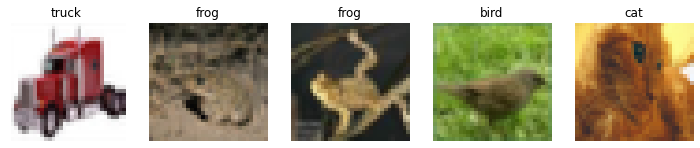

In [5]:
fig = plt.figure(figsize=(25, 5))

for i in range(5):
    fig.add_subplot(2, 10, i + 1)
    image, label = trainset[i]
    plt.imshow(image.permute(1, 2, 0).numpy())
    plt.title(classes[label])
    plt.axis('off')

plt.show()

## Model

Define your model here from scratch (You are not allowed to use the existing models in pytorch)

**NOTICE:** The model that you will have defined outputs a vector containing 10 numbers (for each class). Define a "feature space" that is a vector of size *N* (where *N > 10*) right before the last layer (You can then have a last layer like `nn.Linear(N, 10)`). See the image below to get a better understanding. We will use this later (we want to access the feature space of a sample when the sample is given to the model). The model tries to learn a representation of the samples in this feature space and we will see how good it could do this in later sections.

![Feature Space In Neural Network](https://i.postimg.cc/28Qjcn9D/feature-space-vis.png)

- **Hint I**: Our goal is to get accuracy above *90%* on testset. Our suggestion is to implement ResNet (ResNet18 could be a viable choice)
  - You can learn the network's structure and implementation online (Youtube, ...) and then implmenet it yourself and make changes to enhance it's performance on our task **(YOU SHOULD NOT COPY THE CODE!!! OTHERWISE, YOU'LL BE PENALIZED!!!)**

- **Hint II**: When defining your model, pay attension to the **NOTICE** part in the above. It's also better to read the "Exploring the feature space" section beforehand.  

In [6]:
        
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet12(nn.Module):
    def __init__(self, in_channels, num_classes): 
      super(ResNet12, self).__init__()

      self.conv1 = conv_block(in_channels, 64)
      self.conv2 = conv_block(64, 128, pool=True)
      self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
      
      self.conv3 = conv_block(128, 256, pool=True)
      self.conv4 = conv_block(256, 512, pool=True)
      self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
      
      self.feature = nn.Sequential(nn.MaxPool2d(4), 
                                      nn.Flatten(), 
                                      nn.Dropout(0.2),
                                      )
      self.out = nn.Linear(512, num_classes)
        
    def forward(self, xb):
      out = self.conv1(xb)
      out = self.conv2(out)
      out = self.res1(out) + out
      out = self.conv3(out)
      out = self.conv4(out)
      out = self.res2(out) + out
      out = self.feature(out)
      out = self.out(out)
      return out

    def features(self, x):
      out = self.conv1(x)
      out = self.conv2(out)
      out = self.res1(out) + out
      out = self.conv3(out)
      out = self.conv4(out)
      out = self.res2(out) + out
      out = self.feature(out)
      return out


## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [7]:
net = ResNet12(3, 10).to(device)

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [8]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

### Train loop

Train your model 

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage

In [9]:
val_loss = []
train_loss = []
val_accuracy = []
train_accuracy = []
def train_epoch(net: nn.Module, criterion: nn.Module, optimizer: torch.optim.Optimizer, dataloader: torch.utils.data.DataLoader):
    epoch_loss = 0
    epoch_true = 0
    epoch_all = 0
    i = 0
    
    net.train()
    with tqdm.tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (x, y) in pbar:
            x = x.to(device)
            y = y.to(device)
            p = net(x)

            loss = criterion(p, y)
            epoch_loss += float(loss)

            predictions = p.argmax(-1)
            epoch_all += len(predictions)
            epoch_true += (predictions == y).sum()

            pbar.set_description(f'Loss: {epoch_loss / (i + 1):.3e} - Acc: {epoch_true * 100. / epoch_all:.2f}%')
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
    train_loss.append(epoch_loss / len(dataloader))
    train_accuracy.append(epoch_true / epoch_all)
def eval_epoch(net: nn.Module, criterion: nn.Module, dataloader: torch.utils.data.DataLoader):
    epoch_loss = 0
    epoch_true = 0
    epoch_all = 0
    i = 0

    net.eval()
    with torch.no_grad(), tqdm.tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (x, y) in pbar:
            x = x.to(device)
            y = y.to(device)
            p = net(x)

            loss = criterion(p, y)
            epoch_loss += float(loss)

            predictions = p.argmax(-1)
            epoch_all += len(predictions)
            epoch_true += (predictions == y).sum()

            pbar.set_description(f'Loss: {epoch_loss / (i + 1):.3e} - Acc: {epoch_true * 100. / epoch_all:.2f}%')
    val_loss.append(epoch_loss / len(dataloader))
    val_accuracy.append(epoch_true / epoch_all)

epochs = 40

for e in range(epochs):

    start_time = time()

    train_epoch(net, criterion, optimizer, trainloader)
    eval_epoch(net, criterion, valloader)

    end_time = time()

    print(f'Epoch {e+1:3} finished in {end_time - start_time:.2f}s')

Loss: 9.645e-01 - Acc: 65.72%: 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

Epoch   1 finished in 58.53s



Loss: 8.582e-01 - Acc: 70.94%: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]

Epoch   2 finished in 51.28s



Loss: 5.569e-01 - Acc: 80.98%: 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]

Epoch   3 finished in 51.98s



Loss: 5.089e-01 - Acc: 82.74%: 100%|██████████| 5/5 [00:01<00:00,  3.38it/s]

Epoch   4 finished in 51.08s



Loss: 4.221e-01 - Acc: 86.04%: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

Epoch   5 finished in 51.53s



Loss: 4.629e-01 - Acc: 85.34%: 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]

Epoch   6 finished in 50.93s



Loss: 4.533e-01 - Acc: 86.08%: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]

Epoch   7 finished in 50.49s



Loss: 4.696e-01 - Acc: 87.36%: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]

Epoch   8 finished in 50.15s



Loss: 5.626e-01 - Acc: 85.32%: 100%|██████████| 5/5 [00:01<00:00,  3.38it/s]

Epoch   9 finished in 50.56s



Loss: 5.156e-01 - Acc: 87.36%: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]

Epoch  10 finished in 49.96s



Loss: 5.408e-01 - Acc: 87.42%: 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]

Epoch  11 finished in 49.55s



Loss: 5.912e-01 - Acc: 86.58%: 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]

Epoch  12 finished in 49.83s



Loss: 7.356e-01 - Acc: 85.06%: 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]

Epoch  13 finished in 49.35s



Loss: 5.928e-01 - Acc: 87.24%: 100%|██████████| 5/5 [00:01<00:00,  3.35it/s]

Epoch  14 finished in 49.52s



Loss: 6.070e-01 - Acc: 87.08%: 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]

Epoch  15 finished in 49.70s



Loss: 5.964e-01 - Acc: 87.58%: 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]

Epoch  16 finished in 49.29s



Loss: 5.890e-01 - Acc: 87.76%: 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]

Epoch  17 finished in 50.12s



Loss: 6.670e-01 - Acc: 86.80%: 100%|██████████| 5/5 [00:01<00:00,  3.38it/s]

Epoch  18 finished in 49.54s



Loss: 6.109e-01 - Acc: 88.30%: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]

Epoch  19 finished in 49.77s



Loss: 6.674e-01 - Acc: 87.32%: 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]

Epoch  20 finished in 49.74s



Loss: 7.421e-01 - Acc: 86.44%: 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]

Epoch  21 finished in 49.34s



Loss: 6.777e-01 - Acc: 87.62%: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]

Epoch  22 finished in 49.85s



Loss: 6.194e-01 - Acc: 87.60%: 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]

Epoch  23 finished in 59.99s



Loss: 6.863e-01 - Acc: 87.76%: 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]

Epoch  24 finished in 50.03s



Loss: 8.227e-01 - Acc: 86.44%: 100%|██████████| 5/5 [00:01<00:00,  3.38it/s]

Epoch  25 finished in 49.98s



Loss: 6.612e-01 - Acc: 87.98%: 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]

Epoch  26 finished in 50.90s



Loss: 8.404e-01 - Acc: 86.10%: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]

Epoch  27 finished in 49.66s



Loss: 7.797e-01 - Acc: 88.04%: 100%|██████████| 5/5 [00:01<00:00,  3.38it/s]

Epoch  28 finished in 50.04s



Loss: 8.087e-01 - Acc: 87.20%: 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]

Epoch  29 finished in 49.80s



Loss: 7.935e-01 - Acc: 88.06%: 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]

Epoch  30 finished in 49.90s



Loss: 8.203e-01 - Acc: 87.12%: 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]

Epoch  31 finished in 50.21s



Loss: 8.353e-01 - Acc: 86.78%: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]

Epoch  32 finished in 50.09s



Loss: 7.621e-01 - Acc: 88.00%: 100%|██████████| 5/5 [00:01<00:00,  3.42it/s]

Epoch  33 finished in 50.13s



Loss: 8.014e-01 - Acc: 88.06%: 100%|██████████| 5/5 [00:01<00:00,  3.38it/s]

Epoch  34 finished in 49.84s



Loss: 8.279e-01 - Acc: 87.14%: 100%|██████████| 5/5 [00:01<00:00,  3.42it/s]

Epoch  35 finished in 50.33s



Loss: 7.995e-01 - Acc: 87.68%: 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]

Epoch  36 finished in 49.85s



Loss: 8.310e-01 - Acc: 87.94%: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]

Epoch  37 finished in 50.40s



Loss: 8.775e-01 - Acc: 86.90%: 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]

Epoch  38 finished in 50.05s



Loss: 7.713e-01 - Acc: 87.98%: 100%|██████████| 5/5 [00:01<00:00,  3.38it/s]

Epoch  39 finished in 50.13s



Loss: 9.139e-01 - Acc: 86.42%: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]

Epoch  40 finished in 50.12s


In [10]:
!pip install tqdm
!pip install time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement time (from versions: none)
ERROR: No matching distribution found for time


### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

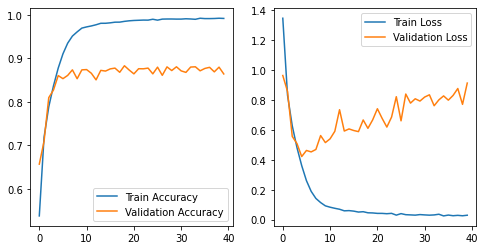

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(list(map(lambda x: x.cpu(), train_accuracy)), label='Train Accuracy')
ax[0].plot(list(map(lambda x: x.cpu(), val_accuracy)), label='Validation Accuracy')
ax[0].legend()
ax[1].plot(train_loss, label='Train Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].legend();


## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `90%`

In [12]:
eval_epoch(net, criterion, testloader)

Loss: 9.048e-01 - Acc: 87.26%: 100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model

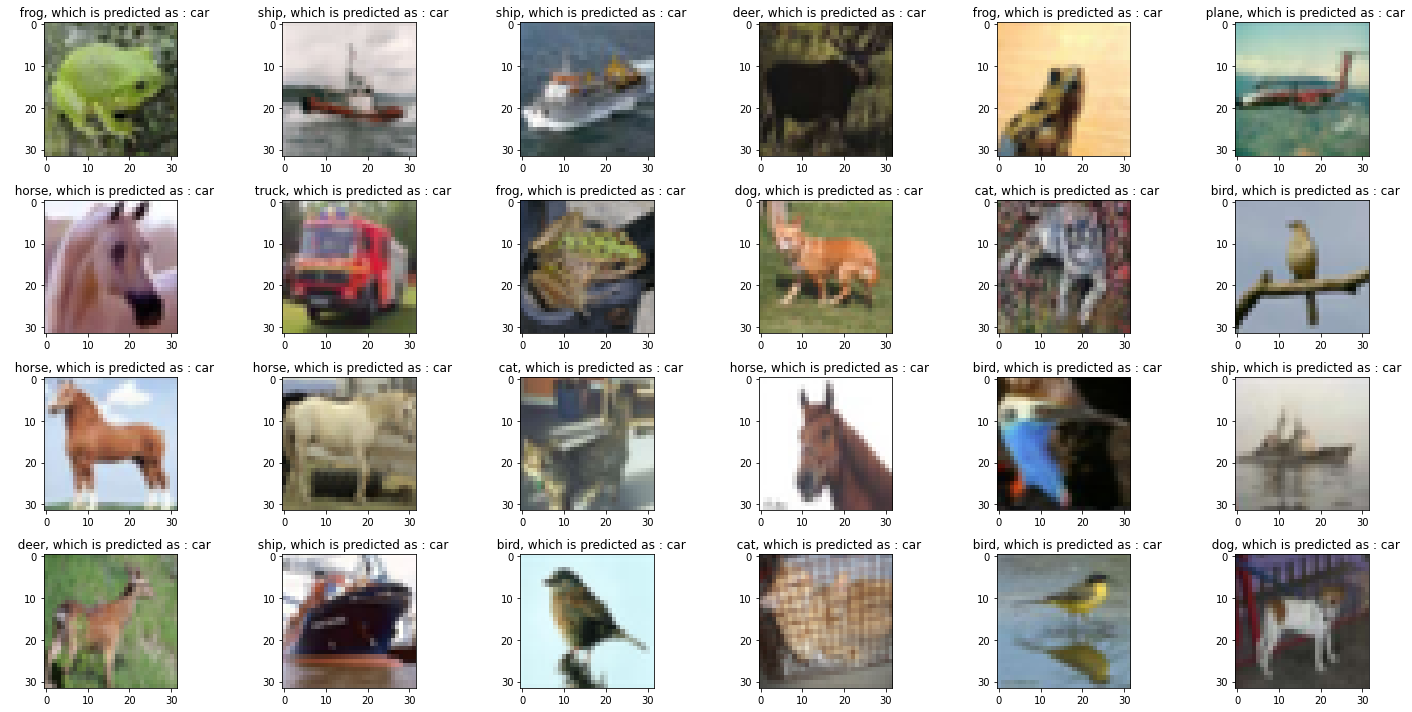

In [13]:

predicted = np.zeros(10000 , dtype = int)
data_to_predict = testset.data
labels_of_data = testset.targets
predicted = np.array(predicted)
for i in range(10000):
  predicted[i] = net(torch.tensor(testset.data[i]).float().permute(2, 0, 1).reshape(1, 3, 32, 32).to(device)).argmax(-1)

fig, ax = plt.subplots(4,6 , figsize=(20, 10))

incorrect_compute = data_to_predict[predicted != labels_of_data]
correct_compute = data_to_predict[predicted == labels_of_data]
predicted_labels_incorrectly = predicted[predicted != labels_of_data]
targets_incorrectly = np.array(labels_of_data)[predicted != labels_of_data]
indices = [np.random.randint(600, len(incorrect_compute)) for _ in range(24)]
indexes = []
for i in range(24):
  indexes.append(np.random.randint(600,len(incorrect_compute)))
for i in range(len(indices)):
  ax[i//6][i%6].imshow(incorrect_compute[indices[i]])
  ax[i//6][i%6].set_title('  ' + classes[targets_incorrectly[indices[i]]] + ', which is predicted as : ' + classes[predicted_labels_incorrectly[indices[i]]])

plt.tight_layout()

## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(50000, N)` saved in a variable (for later usage)

- **Hint 1:** define a tensor with dimension `(50000, N)` where *50000* is the size of the trainset and *N* is the dimension of the feature space

- **Hint 2:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [14]:
from torch.utils.data import DataLoader as DataLoader

In [15]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

train_loader = DataLoader(trainset, batch_size = 16, pin_memory = True,
                          shuffle = False)

test_loader = DataLoader(testset, batch_size = 32, 
                                          pin_memory = True, shuffle = True)

In [16]:
feature_map = torch.zeros((50000, 512), dtype=torch.float32)
i = 0
for images, labels in train_loader:
    images = to_device(images , device)
    with torch.no_grad():
        features = net.features(images)
    feature_map[i: i + len(features)] = features
    i += len(features)


In [17]:

correct_predict = [] 
for images, labels in test_loader:
    images = to_device(images , device)
    with torch.no_grad():
        outputs = net(images)
        features = net.features(images)
    outputs = torch.argmax(outputs, dim=1)
    
    for i in range(32):
          if outputs[i] == labels[i] and len(correct_predict) < 5:
            correct_predict.append((images[i].to('cpu'), features[i].to('cpu')))
    #because we need 5 of them
    if len(correct_predict) == 5:
        break

In [18]:
nearests = [[] for i in range(5)]
for i in range(5):
    temp_map = feature_map - correct_predict[i][1]
    dists = torch.linalg.norm(temp_map,dim = 1)
    indecies = torch.argsort(dists)
    nearests[i] = indecies[:5]
nearests

[tensor([ 8638, 15231,  6923,  8369,   804]),
 tensor([40642, 42868, 36292, 28335,  1153]),
 tensor([18914,  4785,  9896, 34720, 15216]),
 tensor([ 4199, 27144,  1962, 23532, 17841]),
 tensor([17513,    16, 23742, 31615, 31530])]

### K Nearest Neighbor in feature space

You already have calculated the feature spaces for trainset ($S$) in the previous section

1. Get 5 random samples from testset which are correctly predicted by the model. 
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them

**Note:** Your visualization should be something like the below picture

**Hint:** For finding the nearest neighbors in the feature space you can use `torch.linalg.norm` and `torch.topk`

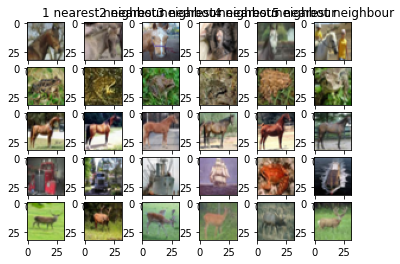

In [19]:

for row in range(5):
    plt.subplot(5, 6, 1 + (row * 6))
    plt.imshow(np.transpose((correct_predict[row][0]), (1, 2, 0)))
    for col in range(5):
        image = trainset[nearests[row][col]][0]
        plt.subplot(5, 6, 2 + (row * 6) + col)
        plt.imshow(np.transpose((image), (1, 2, 0)))
        if row == 0:
          plt.title('{0} nearest neighbour'.format( col+1 ))

### TSNE 

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections) 
2. Now you a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now you have a vector of size `(M, 2)`)
4. Print the shape of the output

**Hint:** You can use `sklearn.manifold.TSNE`

In [20]:
feature_label = []
for i in range(10000):
    feature_label.append((feature_map[i], trainset[i][1]))
samples = []
for i in range(2000):
    samples.append(np.random.randint(0,10000))
feature_samples = feature_map[samples]
tsne = TSNE(n_components = 2).fit_transform(feature_samples)
tsne.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(2000, 2)

Visualize the points in a 2D plane (Set color of each point based on it's class)

**Notice:** Your visualization should be something like the below image

**Hint:** Use `plt.scatter(x, y, c=labels)`

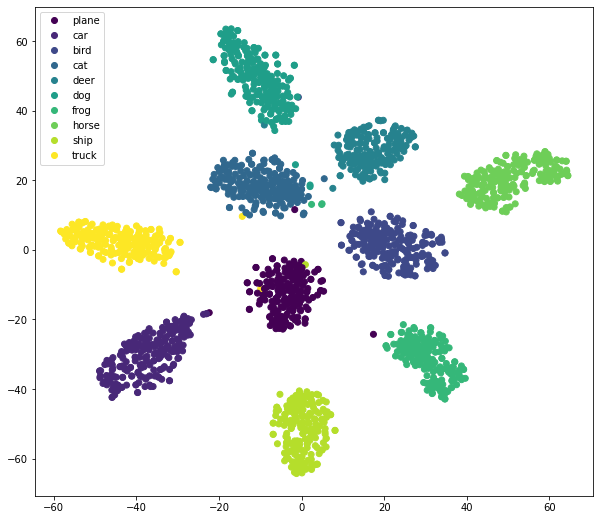

In [21]:
plt.rcParams["figure.figsize"] = (10,9)
scatter = plt.scatter(x = list(tsne.T[0]), y = list(tsne.T[1]), c = [trainset[x][1] for x in samples])
plt.legend(handles=scatter.legend_elements()[0], labels=classes)